采用CLAHE方法  
进行 LAB 颜色空间转换

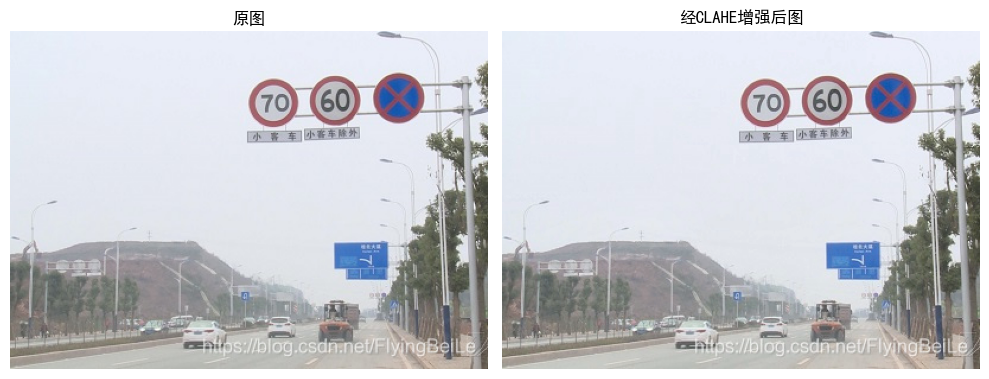

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 读取图像 "F:\\baidudownload\\traffic_sign.jpg"  "F:\\baidudownload\\R.jpg"
image_path = "F:\\baidudownload\\traffic_sign.jpg"
RGB = cv2.imread(image_path)

# 将 BGR 转换为 RGB
RGB = cv2.cvtColor(RGB, cv2.COLOR_BGR2RGB)

# 将 RGB 转换到 LAB 颜色空间
LAB = cv2.cvtColor(RGB, cv2.COLOR_RGB2Lab)

# 提取亮度通道
L = LAB[:, :, 0] / 255.0  # LAB 中的亮度通道

# 应用 CLAHE
clahe = cv2.createCLAHE(clipLimit=0.005, tileGridSize=(8, 8))
L_clahe = clahe.apply((L * 255).astype(np.uint8))

# 将增强后的亮度通道放回 LAB 颜色空间
LAB[:, :, 0] = L_clahe

# 转换回 RGB 颜色空间
J = cv2.cvtColor(LAB, cv2.COLOR_Lab2RGB)

# 显示原图和增强后的图像
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(RGB)
plt.title('原图')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(J)
plt.title('经CLAHE增强后图')
plt.axis('off')

plt.tight_layout()
plt.show()

转换到 HSV 颜色空间

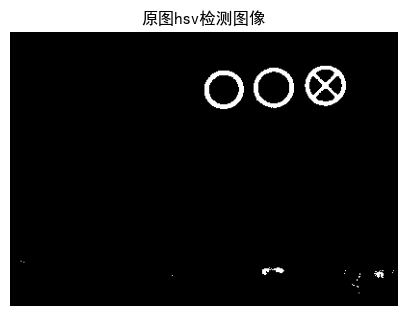

In [2]:
# 转换到 HSV 颜色空间
hsv = cv2.cvtColor(J, cv2.COLOR_RGB2HSV)

# 提取 H、S 和 V 分量
h1 = hsv[:,:,0] / 180.0  # OpenCV 的 H 分量范围是 [0, 179]
s1 = hsv[:,:,1] / 255.0  # S 分量范围是 [0, 255]
v1 = hsv[:,:,2] / 255.0  # V 分量范围是 [0, 255]

# 提取红色分量
hsvR = ((h1 <= 0.056) | (h1 >= 0.740)) & (s1 >= 0.169) & (s1 <= 1.0) & (v1 >= 0.180) & (v1 <= 1.0)

# 显示 HSV 检测图像
plt.figure(figsize=(5, 5))
plt.imshow(hsvR, cmap='gray')
plt.title('原图hsv检测图像')
plt.axis('off')
plt.show()

绘制方框并切割

离心率: 0.24085334658678612
离心率: 0.22132164002785623
离心率: 0.18175903499901147


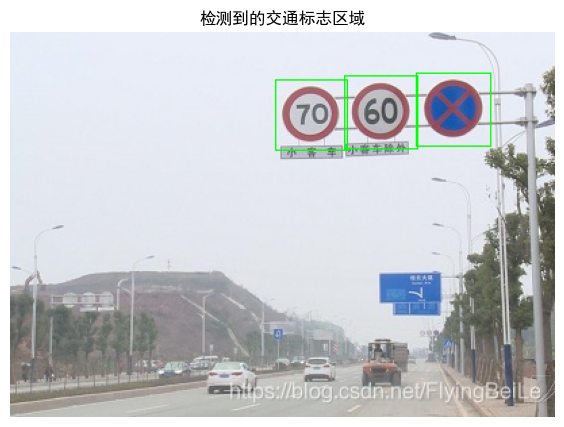

In [3]:
# 转换为 uint8 格式以便进行轮廓检测
hsvR_uint8 = (hsvR * 255).astype(np.uint8)

# 寻找轮廓
contours, _ = cv2.findContours(hsvR_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 初始化参数
area_threshold = 800  # 面积阈值，可以根据需要调整

# 在原图上绘制边框
output_image = RGB.copy()
save_counter = 0  # 用于保存切割图片时命名

for contour in contours:
    area = cv2.contourArea(contour)  # 计算轮廓面积
    if area > area_threshold:  # 只考虑大于阈值的轮廓
        # 计算轮廓的离心率
        (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
        if MA < ma:
            MA, ma = ma, MA  # 交换 MA 和 ma
        if MA > 0 and ma > 0:  # 确保 MA 和 ma 都大于零
            eccentricity = np.sqrt(1 - (ma / MA) ** 2)  # 离心率计算
            print(f"离心率: {eccentricity}")

            # 如果离心率符合条件，则绘制边框
            if eccentricity > 0 and eccentricity < 0.5 :
                # 计算边框坐标
                x, y, w, h = cv2.boundingRect(contour)
                padding = 6
                x -= padding
                y -= padding
                w += 2 * padding
                h += 2 * padding
                cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 1)

                # 切割并保存图片
                cropped_image = RGB[y:y + h, x:x + w]
                crop_image_path = f"F:\\baidudownload\\GTSRB_Test_Images\\GTSRB\\Final_Test\\Images\\0000{save_counter}.ppm"  # 保存的图片文件名
                cv2.imwrite(crop_image_path, cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))  # 保存为PPM格式
                save_counter += 1

# 显示结果图像
plt.figure(figsize=(10, 5))
plt.imshow(output_image)
plt.title('检测到的交通标志区域')
plt.axis('off')
plt.show()

对切割后的图像计算信息：
- Width: 图片宽度（像素）
- Height: 图片高度（像素）
- ROI.x1: 交通标志图像左上角位置的X轴坐标信息
- ROI.y1: 交通标志图像左上角位置的Y轴坐标信息
- ROI.x2: 交通标志图像右下角位置的X轴坐标信息
- ROI.y2: 交通标志图像右下角位置的Y轴坐标信息

00000.ppm - 离心率: 0.23678583042219106


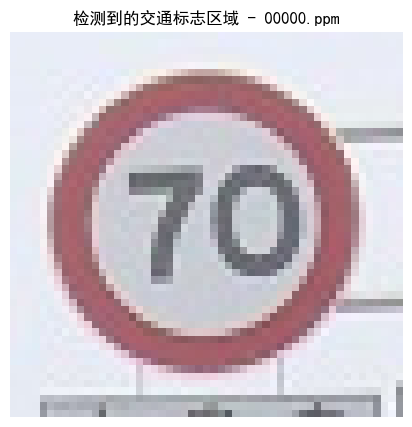

00001.ppm - 离心率: 0.2082677481786759


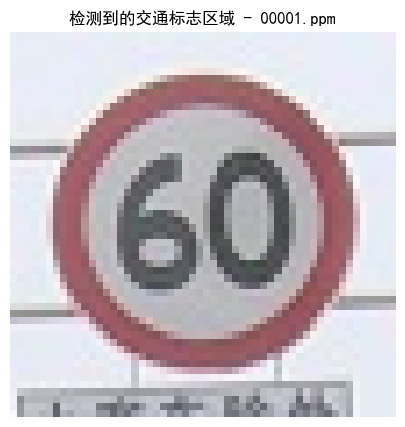

00002.ppm - 离心率: 0.1752906553021545


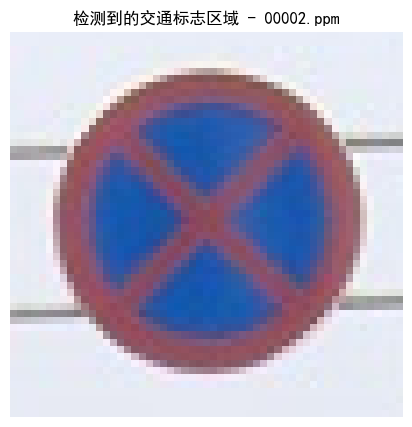

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

# 图片文件夹路径
image_folder = r"F:\\baidudownload\\GTSRB_Test_Images\\GTSRB\\Final_Test\\Images"

# 要写入的 CSV 文件名
csv_file = os.path.join(image_folder, "GT-final_test.csv")

# 遍历文件夹中的每张图片
for filename in os.listdir(image_folder):
    if filename.endswith(".ppm"):  # 确保只处理 .ppm 文件
        image_path = os.path.join(image_folder, filename)

        # 读取图像
        RGB = cv2.imread(image_path)
        
        # 检查图像是否成功读取
        if RGB is None:
            print(f"无法读取图像 {filename}")
            continue
        
        # 获取图像的高度和宽度
        height, width = RGB.shape[:2]

        # 将 BGR 转换为 RGB
        RGB = cv2.cvtColor(RGB, cv2.COLOR_BGR2RGB)

        # 将 RGB 转换到 LAB 颜色空间
        LAB = cv2.cvtColor(RGB, cv2.COLOR_RGB2Lab)

        # 提取亮度通道
        L = LAB[:, :, 0] / 255.0

        # 应用 CLAHE
        clahe = cv2.createCLAHE(clipLimit=0.005, tileGridSize=(8, 8))
        L_clahe = clahe.apply((L * 255).astype(np.uint8))

        # 将增强后的亮度通道放回 LAB 颜色空间
        LAB[:, :, 0] = L_clahe

        # 转换回 RGB 颜色空间
        J = cv2.cvtColor(LAB, cv2.COLOR_Lab2RGB)

        # 转换到 HSV 颜色空间
        hsv = cv2.cvtColor(J, cv2.COLOR_RGB2HSV)

        # 提取 H、S 和 V 分量
        h1 = hsv[:, :, 0] / 180.0
        s1 = hsv[:, :, 1] / 255.0
        v1 = hsv[:, :, 2] / 255.0

        # 提取红色分量
        hsvR = ((h1 <= 0.056) | (h1 >= 0.740)) & (s1 >= 0.169) & (s1 <= 1.0) & (v1 >= 0.180) & (v1 <= 1.0)

        # 转换为 uint8 格式以便进行轮廓检测
        hsvR_uint8 = (hsvR * 255).astype(np.uint8)

        # 寻找轮廓
        contours, _ = cv2.findContours(hsvR_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 初始化参数
        area_threshold = 800  # 面积阈值

        # 在原图上绘制边框
        output_image = RGB.copy()

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > area_threshold:
                # 计算轮廓的离心率
                (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
                if MA < ma:
                    MA, ma = ma, MA
                if MA > 0 and ma > 0:
                    eccentricity = np.sqrt(1 - (ma / MA) ** 2)
                    print(f"{filename} - 离心率: {eccentricity}")

                    # 如果离心率符合条件，则绘制边框并保存数据
                    if 0 < eccentricity < 0.5:
                        # 计算边框坐标
                        x, y, w, h = cv2.boundingRect(contour)
                        
                        padding = 1
                        x -= padding
                        y -= padding
                        w += 2 * padding
                        h += 2 * padding

                        # 写入 CSV 文件
                        data_row = [filename, width, height, x, y, x + w, y + h]
                        with open(csv_file, mode='a', newline='', encoding='utf-8') as file:
                            writer = csv.writer(file, delimiter=';')
                            writer.writerow(data_row)

        # 显示当前图像的处理结果
        plt.figure(figsize=(10, 5))
        plt.imshow(output_image)
        plt.title(f"检测到的交通标志区域 - {filename}")
        plt.axis('off')
        plt.show()



对交通标志进行识别

In [5]:
def load_image(image_file):
    return plt.imread(image_file) # 读取图片

In [6]:
# 读取图片并调整图片尺寸为(32,32)
def resize_image(image_file, shape=(32,32)): # image_file:图片文件地址
    image_list=[]
    for image_file_n in image_file:
        image_file_n
        image=load_image(image_file_n)
        image=cv2.resize(image, shape)
        image_list.append(image)
    image=np.array(image_list)
    return image  # 输出:存储的调整后的图片文件

In [7]:
import pandas as pd
import glob

sign_name_df = pd.read_csv("E:\\python\\.vscode\\GTSRB_Training_Images\\GTSRB\\signnames.csv", index_col='ClassId') # 读取各交通标志名并存储
SIGN_NAMES = sign_name_df.SignName.values  # 获取交通标志名称，存储在SIGN_NAMES
SIGN_NAMES[0]  

'Speed limit (20km/h)'

In [8]:
Test_IMAGE_DIR = "F:\\baidudownload\\GTSRB_Test_Images\\GTSRB\\Final_Test" #此处为文件夹地址

test_file=glob.glob(os.path.join(Test_IMAGE_DIR, '*/GT-*.csv'))
# print(test_file)
folder = test_file[0].split('\\')[5]
# print(folder)
test_df = pd.read_csv(test_file[0], sep=';')                     #读取文件夹中csv文件
test_df['Filename'] = test_df['Filename'].apply(lambda x: os.path.join(Test_IMAGE_DIR,folder, x))#将‘Filename'列内容延展，增加文件地址
test_df

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2
0,F:\baidudownload\GTSRB_Test_Images\GTSRB\Final...,53,52,5,4,48,47
1,F:\baidudownload\GTSRB_Test_Images\GTSRB\Final...,54,54,5,5,49,49
2,F:\baidudownload\GTSRB_Test_Images\GTSRB\Final...,55,54,5,5,50,49


In [9]:
print("Number of test images: {:>5}".format(test_df.shape[0]))

Number of test images:     3


In [10]:
X_test = resize_image(test_df['Filename'].values) #读取图片并调整尺寸
X_test = X_test.astype('float32')

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten

@tf.keras.utils.register_keras_serializable()
class LeNet(tf.keras.Model):
    def __init__(self):
        super(LeNet, self).__init__()
        # 超参数设置
        self.conv1 = tf.keras.layers.Conv2D(6, (5, 5), activation='relu', padding='valid')
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='valid')
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(120, activation='relu')
        self.fc2 = tf.keras.layers.Dense(84, activation='relu')
        self.output_layer = tf.keras.layers.Dense(43, activation='softmax')

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        if training:
            x = tf.nn.dropout(x, rate=1 - 1)  # keep_prob为1时不应用dropout
        return self.output_layer(x)

    def get_config(self):
        config = super(LeNet, self).get_config()
        config.pop('name', None)  # 删除多余的 'name' 参数
        # 添加其他需要的参数
        return config


    @classmethod
    def from_config(cls, config):
        config.pop('trainable', None)  # 删除 'trainable' 参数
        config.pop('dtype', None)       # 删除 'dtype' 参数
        return cls(**config)




In [12]:
from tensorflow.keras.models import load_model

# 加载模型
model = load_model("E:\\python\\.vscode\\Traffic_Signal_Classifier-CNN\\cnn_model\\lenet.keras")

# 获取测试集的预测结果
predictions = model.predict(X_test)

# 如果需要，可以将预测结果转换为类标签
predicted_classes = predictions.argmax(axis=1)
predicted_labels = [SIGN_NAMES[class_id] for class_id in predicted_classes]

# 打印预测结果
print("Predicted Classes:")
for label in predicted_labels:
    print(label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Predicted Classes:
Speed limit (70km/h)
Speed limit (60km/h)
Keep left
